# preparation

In [1]:
!nvidia-smi
import torch
torch.cuda.is_available()

Fri Jun 10 11:04:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:5C:00.0 Off |                    0 |
| N/A   44C    P0    29W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

# CNNs

## CNN-1

In [4]:
# Load in relevant libraries, and alias where appropriate
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Define relevant variables for the ML task
batch_size = 64
num_classes = 10
learning_rate = 0.01
num_epochs = 20

# specifiy the model store path


# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')



print(device)

cuda:0


In [5]:
# Use transforms.compose method to reformat images for modeling,
# and save to variable all_transforms for later use
all_transforms = transforms.Compose([transforms.Resize((32,32)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                                          std=[0.2023, 0.1994, 0.2010])
                                     ])
# Create Training dataset
train_dataset = torchvision.datasets.CIFAR10(root = './data',
                                             train = True,
                                             transform = all_transforms,
                                             download = True)

# Create Testing dataset
test_dataset = torchvision.datasets.CIFAR10(root = './data',
                                            train = False,
                                            transform = all_transforms,
                                            download=True)

# Instantiate loader objects to facilitate processing
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)


test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Creating a CNN class
class ConvNeuralNet(nn.Module):
	#  Determine what layers and their order in CNN object 
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.fc1 = nn.Linear(1600, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
    
    # Progresses data across layers    
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.max_pool1(out)
        
        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = self.max_pool2(out)
                
        out = out.reshape(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [7]:
model = ConvNeuralNet(num_classes)

# Set Loss function with criterion
criterion = nn.CrossEntropyLoss()

# Set optimizer with optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

total_step = len(train_loader)


In [8]:
print(device)

cuda:0


In [ ]:
# We use the pre-defined number of epochs to determine how many iterations to train the network on
for epoch in range(num_epochs):
	#Load in the data in batches using the train_loader object
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        model = model.cuda()
        # 同样需要调整model去成为cuda的类型
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Epoch [1/20], Loss: 1.2008
Epoch [2/20], Loss: 0.7755
Epoch [3/20], Loss: 0.9693
Epoch [4/20], Loss: 0.8719
Epoch [5/20], Loss: 1.0677
Epoch [6/20], Loss: 1.1875


In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        model = model.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network on the {} train images: {} %'.format(50000, 100 * correct / total))




## CNN-2

In [8]:
# import the modules
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets
from bokeh.plotting import figure
from bokeh.io import show
from bokeh.models import LinearAxis, Range1d
import numpy as np
# Hyperparameters
num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.001
DATA_PATH = './data_minist'
MODEL_STORE_PATH = './models_cnn'

# transforms to apply to the data
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
# transforms.Compose(): 
# torchvision,which allows the daveloper to setip various manipulation on the specified dataset
# transpose from dataset to tensor
# tensor(a specific data type used in PyTorch for all of the various data and 
# weight operations within the network.)

# PyTorch Normalize transform, we need to supply the mean and standard deviation of the MNIST dataset,
#  which in this case is 0.1307 and 0.3081 respectively

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

# both the train and test datasets have been created, it is time to load them into the data loader:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# ??why the test loader don't need to suffle
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
class ConvNet(nn.Module):
  # the nn.module creates a set of Conv-filters
  def __init__(self):
    super(ConvNet,self).__init__()
    self.layer1 = nn.Sequential(
      # single channel grayscale hence the input channel is 1
      # kernel_size argument is the size of the convolutional filter – 
      # in this case we want 5 x 5 sized convolutional filters 
        nn.Conv2d(1,32,kernel_size=5,stride=1,padding=2),
        # out = (in - kernal_size + 2padding)/stride+1
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2,padding=0)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(32,64,kernel_size=5,stride=1,padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2,padding=0)
    )
    # drop-out layer to avoid over-fitting in the model.
    self.drop_out = nn.Dropout()
    self.fc1 = nn.Linear(7*7*64,1000)
    self.fc2 = nn.Linear(1000,10)
    # The first argument to this method is the number of nodes in the layer
    # and the second argument is the number of nodes in the following layer.

  def forward(self,x):
      out = self.layer1(x)
      out = self.layer2(out)
      out = out.reshape(out.size(0),-1)
      # here we get 7*7*64 -> 3164 * 1 (reshaped)
      out = self.drop_out(out)
      out = self.fc1(out)
      out = self.fc2(out)
      return out
   

In [10]:
 
model = ConvNet()
# loss and optimizer
criterion = nn.CrossEntropyLoss()
# CrossEntropyLoss function combines both a 
# SoftMax activation 
# and a cross entropy loss function in the same function – winning
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)
# what is adam?

# Train the model
total_step = len(train_loader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Run the forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)
        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/5], Step [100/600], Loss: 0.1435, Accuracy: 96.00%
Epoch [1/5], Step [200/600], Loss: 0.1282, Accuracy: 94.00%
Epoch [1/5], Step [300/600], Loss: 0.1193, Accuracy: 97.00%
Epoch [1/5], Step [400/600], Loss: 0.0435, Accuracy: 99.00%
Epoch [1/5], Step [500/600], Loss: 0.0621, Accuracy: 97.00%
Epoch [1/5], Step [600/600], Loss: 0.1438, Accuracy: 95.00%
Epoch [2/5], Step [100/600], Loss: 0.0391, Accuracy: 98.00%
Epoch [2/5], Step [200/600], Loss: 0.0798, Accuracy: 98.00%
Epoch [2/5], Step [300/600], Loss: 0.0809, Accuracy: 97.00%
Epoch [2/5], Step [400/600], Loss: 0.1540, Accuracy: 97.00%
Epoch [2/5], Step [500/600], Loss: 0.0414, Accuracy: 98.00%
Epoch [2/5], Step [600/600], Loss: 0.0306, Accuracy: 99.00%
Epoch [3/5], Step [100/600], Loss: 0.0133, Accuracy: 100.00%
Epoch [3/5], Step [200/600], Loss: 0.0826, Accuracy: 97.00%
Epoch [3/5], Step [300/600], Loss: 0.0074, Accuracy: 100.00%
Epoch [3/5], Step [400/600], Loss: 0.1182, Accuracy: 96.00%
Epoch [3/5], Step [500/600], Loss: 0.0

In [11]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

# Save the model and plot
torch.save(model.state_dict(), MODEL_STORE_PATH + 'conv_net_model.ckpt')

p = figure(y_axis_label='Loss', width=850, y_range=(0, 1), title='PyTorch ConvNet results')
p.extra_y_ranges = {'Accuracy': Range1d(start=0, end=100)}
p.add_layout(LinearAxis(y_range_name='Accuracy', axis_label='Accuracy (%)'), 'right')
p.line(np.arange(len(loss_list)), loss_list)
p.line(np.arange(len(loss_list)), np.array(acc_list) * 100, y_range_name='Accuracy', color='red')
show(p)


Test Accuracy of the model on the 10000 test images: 99.0 %


## MINIST手写数字

In [10]:

import numpy as np
import torch 
from torch import nn
from PIL import Image
import matplotlib.pyplot as plt
import os
from torchvision import datasets, transforms,utils

In [11]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean=[0.5],std=[0.5])])
train_data = datasets.MNIST(root = "./data/",
                            transform=transform,
                            train = True,
                            download = True)

test_data = datasets.MNIST(root="./data/",
                           transform = transform,
                           train = False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [12]:

train_loader = torch.utils.data.DataLoader(train_data,batch_size=64,
                                          shuffle=True,num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=64,
                                          shuffle=True,num_workers=2)

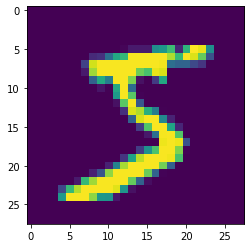

In [13]:
oneimg,label = train_data[0]
oneimg = oneimg.numpy().transpose(1,2,0) 
std = [0.5]
mean = [0.5]
oneimg = oneimg * std + mean
oneimg.resize(28,28)
plt.imshow(oneimg)
plt.show()

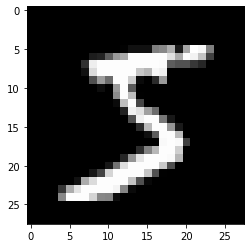

In [14]:
oneimg,label = train_data[0]
grid = utils.make_grid(oneimg)
grid = grid.numpy().transpose(1,2,0) 
std = [0.5]
mean = [0.5]
grid = grid * std + mean
plt.imshow(grid)
plt.show()

<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_2110193/3262706860.py:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if i%8 is 0:


tensor(2) tensor(9) tensor(9) tensor(1) tensor(3) tensor(4) tensor(2) tensor(5) 
tensor(2) tensor(1) tensor(0) tensor(7) tensor(8) tensor(4) tensor(7) tensor(7) 
tensor(2) tensor(7) tensor(4) tensor(7) tensor(2) tensor(4) tensor(2) tensor(7) 
tensor(9) tensor(8) tensor(7) tensor(5) tensor(6) tensor(6) tensor(9) tensor(4) 
tensor(7) tensor(7) tensor(5) tensor(1) tensor(1) tensor(1) tensor(2) tensor(0) 
tensor(7) tensor(8) tensor(8) tensor(6) tensor(0) tensor(8) tensor(4) tensor(5) 
tensor(5) tensor(1) tensor(7) tensor(1) tensor(4) tensor(2) tensor(3) tensor(1) 
tensor(5) tensor(8) tensor(6) tensor(8) tensor(2) tensor(2) tensor(5) tensor(9) 


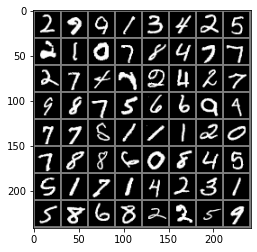

In [15]:
images, lables = next(iter(train_loader))
img = utils.make_grid(images)
# transpose 转置函数(x=0,y=1,z=2),新的x是原来的y轴大小，新的y是原来的z轴大小，新的z是原来的x大小
#相当于把x=1这个一道最后面去。
img = img.numpy().transpose(1,2,0) 
std = [0.5]
mean = [0.5]
img = img * std + mean
for i in range(64):
    print(lables[i], end=" ")
    i += 1
    if i%8 is 0:
        print(end='\n')
plt.imshow(img)
plt.show()


In [16]:
import torch.nn.functional as F
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(1,32,kernel_size=3,stride=1,padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1)
        self.fc1 = nn.Linear(64*7*7,1024)#两个池化，所以是7*7而不是14*14
        self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(512,10)
#         self.dp = nn.Dropout(p=0.5)
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(-1, 64 * 7* 7)#将数据平整为一维的 
        x = F.relu(self.fc1(x))
#         x = self.fc3(x)
#         self.dp(x)
        x = F.relu(self.fc2(x))   
        x = self.fc3(x)  
#         x = F.log_softmax(x,dim=1) NLLLoss()才需要，交叉熵不需要
        return x

net = CNN()

In [17]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#也可以选择Adam优化方法
optimizer = torch.optim.Adam(net.parameters(),lr=1e-2)


In [ ]:
train_accs = []
train_loss = []
test_accs = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)
for epoch in range(3):
    running_loss = 0.0
    for i,data in enumerate(train_loader,0):#0是下标起始位置默认为0
        # data 的格式[[inputs, labels]]       
#         inputs,labels = data
        inputs,labels = data[0].to(device), data[1].to(device)
        #初始为0，清除上个batch的梯度信息
        optimizer.zero_grad()         

        #前向+后向+优化     
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        # loss 的输出，每个一百个batch输出，平均的loss
        running_loss += loss.item()
        if i%100 == 99:
            print('[%d,%5d] loss :%.3f' %
                 (epoch+1,i+1,running_loss/100))
            running_loss = 0.0
        train_loss.append(loss.item())

        # 训练曲线的绘制 一个batch中的准确率
        correct = 0
        total = 0
        _, predicted = torch.max(outputs.data, 1)
        total = labels.size(0)# labels 的长度
        correct = (predicted == labels).sum().item() # 预测正确的数目
        train_accs.append(100*correct/total)

print('Finished Training')

# Visualising_image

In [24]:

import os
import torch
import sys
import numpy as np
import glob
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append("../")

try:
   import config_farm
   print("successfully imported")
except:
    print("not working")

paths_list = glob.glob(os.path.join('../../pravirat/Realsat_labelling/WARPED_DATA/350_400_stage2_warped_64x64/*.npy'))

# print(len(paths_list))

continent_info = np.load('/home/kumarv/pravirat/Realsat_labelling/continent_info.npy')
continent_no = 2 

path_list = []
for path in paths_list:
    ID = path.split('/')[-1].split('_')[-4]
    if(continent_info[int(ID)] == continent_no):
        path_list.append(path)
        
print(len(path_list))

successfully imported
8642


### get the fractional map

../../pravirat/Realsat_labelling/WARPED_DATA/350_400_stage2_warped_64x64/ID_731630_orbit_updated_warped.npy


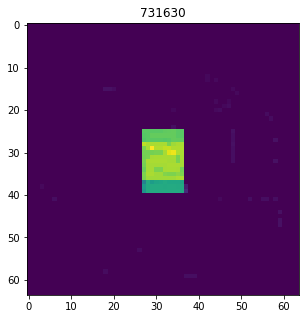

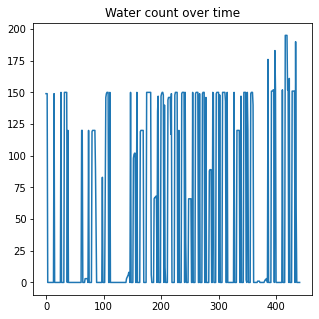

../../pravirat/Realsat_labelling/WARPED_DATA/350_400_stage2_warped_64x64/ID_731328_orbit_updated_warped.npy


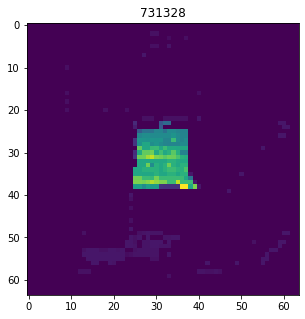

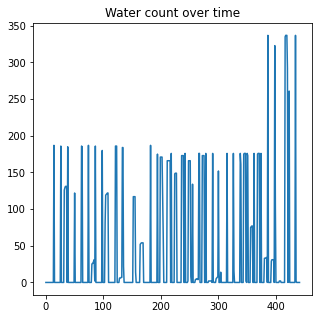

../../pravirat/Realsat_labelling/WARPED_DATA/350_400_stage2_warped_64x64/ID_730504_orbit_updated_warped.npy


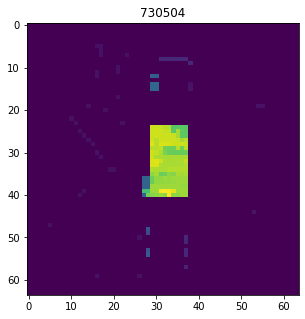

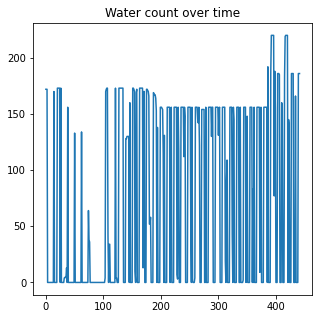

../../pravirat/Realsat_labelling/WARPED_DATA/350_400_stage2_warped_64x64/ID_730545_orbit_updated_warped.npy


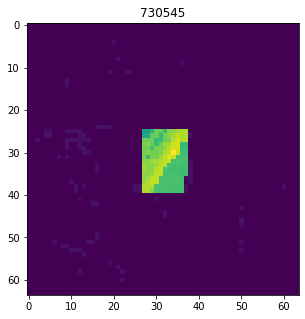

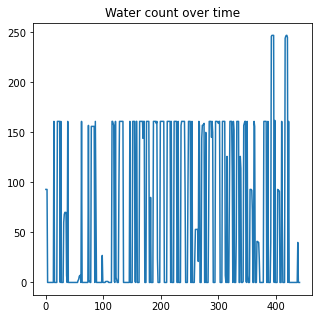

../../pravirat/Realsat_labelling/WARPED_DATA/350_400_stage2_warped_64x64/ID_734435_orbit_updated_warped.npy


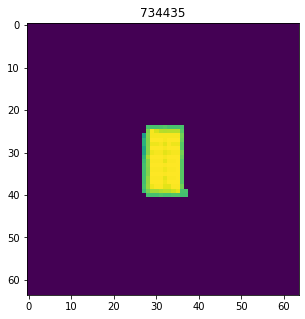

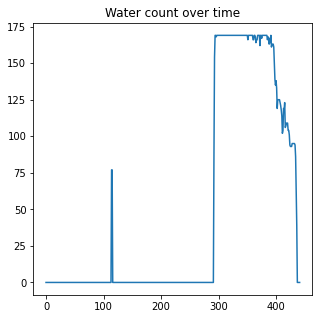

../../pravirat/Realsat_labelling/WARPED_DATA/350_400_stage2_warped_64x64/ID_734214_orbit_updated_warped.npy


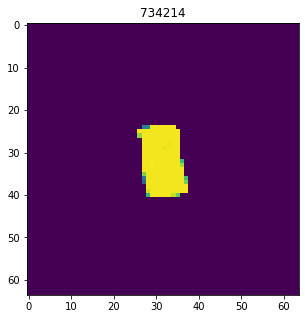

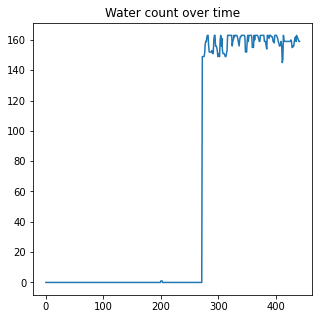

../../pravirat/Realsat_labelling/WARPED_DATA/350_400_stage2_warped_64x64/ID_730304_orbit_updated_warped.npy


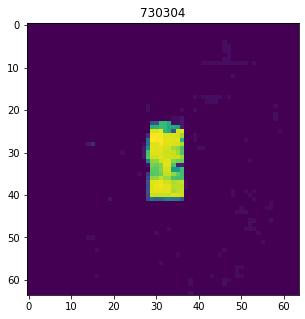

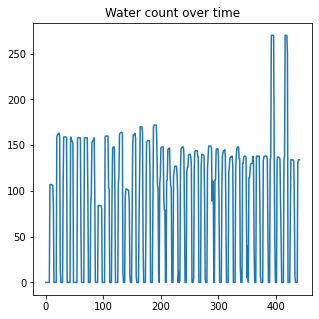

../../pravirat/Realsat_labelling/WARPED_DATA/350_400_stage2_warped_64x64/ID_689616_orbit_updated_warped.npy


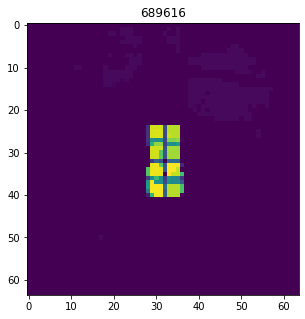

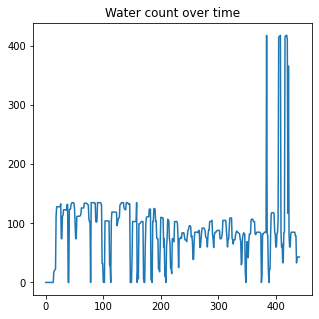

../../pravirat/Realsat_labelling/WARPED_DATA/350_400_stage2_warped_64x64/ID_731761_orbit_updated_warped.npy


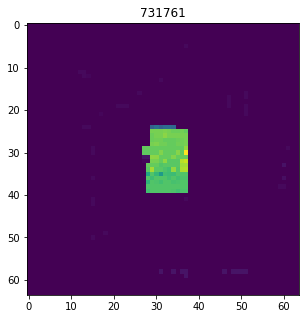

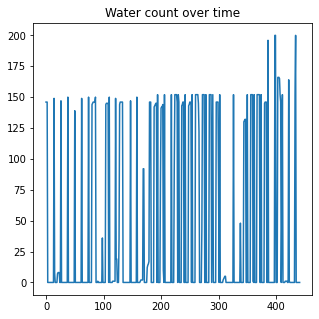

../../pravirat/Realsat_labelling/WARPED_DATA/350_400_stage2_warped_64x64/ID_683693_orbit_updated_warped.npy


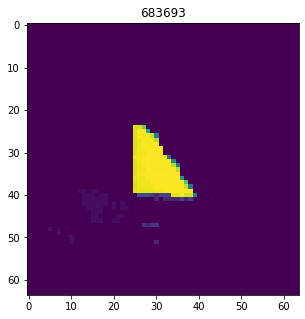

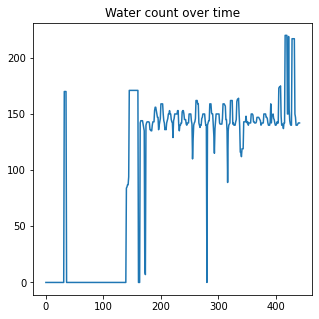

../../pravirat/Realsat_labelling/WARPED_DATA/350_400_stage2_warped_64x64/ID_730997_orbit_updated_warped.npy


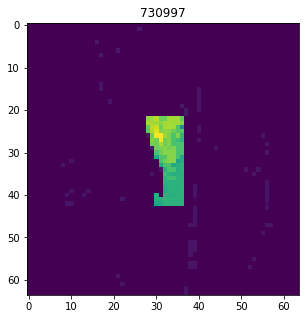

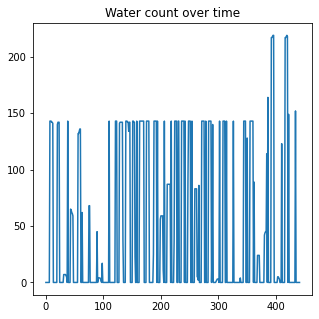

../../pravirat/Realsat_labelling/WARPED_DATA/350_400_stage2_warped_64x64/ID_731571_orbit_updated_warped.npy


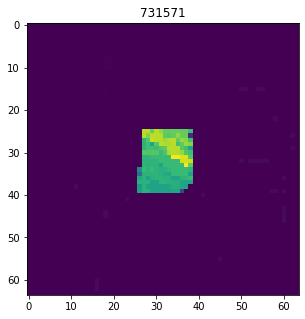

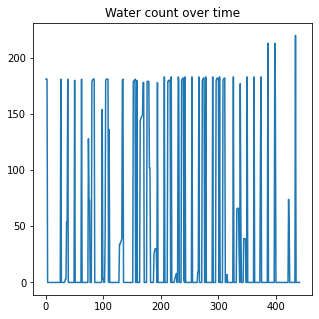

../../pravirat/Realsat_labelling/WARPED_DATA/350_400_stage2_warped_64x64/ID_731631_orbit_updated_warped.npy


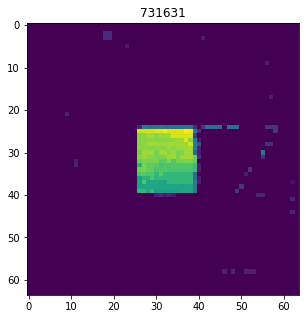

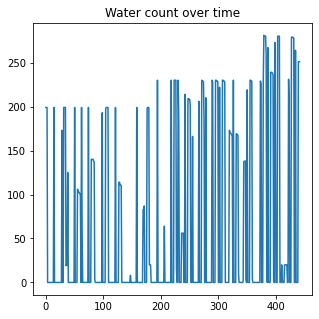

../../pravirat/Realsat_labelling/WARPED_DATA/350_400_stage2_warped_64x64/ID_731813_orbit_updated_warped.npy


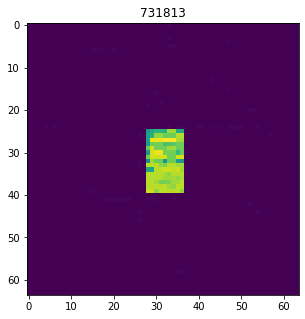

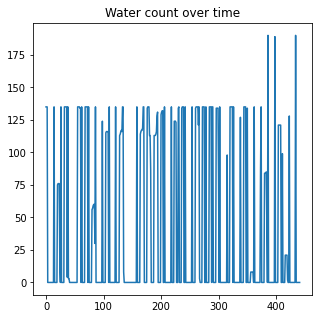

../../pravirat/Realsat_labelling/WARPED_DATA/350_400_stage2_warped_64x64/ID_731723_orbit_updated_warped.npy


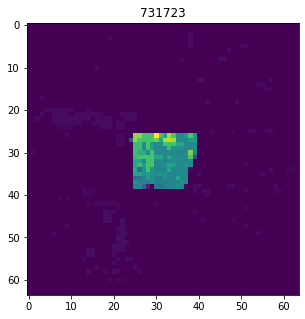

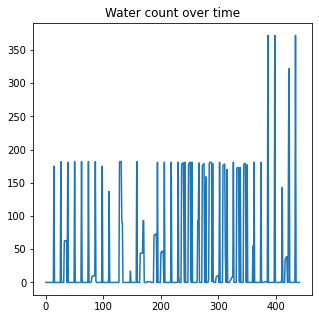

In [39]:
# load ID of image of interest
ID = 626849
labeled_farm=[731630,731328,730504,730545,734435,734214,730304,68165,689616,731761,683693,730997,731571,731631,731813,731723]
labeled_none_farm_stage1 = [418841,463564,520007,547329,540241,622357,693164,558950,573960,554503,463607,414370,519837,5215855,40108,629826]

# i = 0
for i,d in enumerate(labeled_farm):
    ID = labeled_farm[i]
    for path in paths_list:
    #     print(path)
        ID_path = path.split('/')[-1].split('_')[-4]
        if int(ID) == int(ID_path):      
            path_final = path
            # print(ID)
            # print(i)
            image = np.load(path_final)
            print(path_final)
            # converting image to binary
            image[image == 1] = 0
            image[image == 2] = 1

            # take mean over timestamps to create fraction map
            frac_map = np.mean(image,axis = 0)
            # plotting the fraction map
            fig = plt.figure(figsize=(5,5))
            plt.title(labeled_farm[i])
            plt.imshow(frac_map[0])
            plt.show()
            #count number of water pixels timestamp wise
            water_pixels = []
            for t in range(image.shape[0]):
                no_water = np.sum(image[t] == 1)
                water_pixels.append(no_water)

            # plotting that time series 
            fig = plt.figure(figsize=(5,5))
            plt.title('Water count over time')
            plt.plot(water_pixels)
            plt.show()

# # create timeseries for ID

# # load ID numpy arary
# image = np.load(path_final)

# # converting image to binary
# image[image == 1] = 0
# image[image == 2] = 1



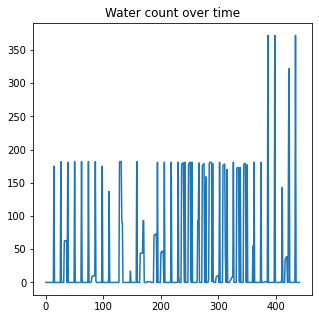

# step1: label the data and train

In [16]:
labeled_farm=[731630,731328,730504,730545,734435,734214,730304,68165,689616,731761,683693,730997,731571,731631,731813,731723]
labeled_none_farm_stage1 = [418841,463564,520007,547329,540241,622357,693164,558950,573960,554503,463607,414370,519837,5215855,40108,629826]

# (len(labeled_farm) == len(labeled_none_farm_stage1))




True

In [43]:
!ls ../../pravirat/Realsat_labelling/WARPED_DATA/
!mkdir ../../pravirat/Realsat_labelling/WARPED_DATA/labled_farm_stage1
!ls ../../pravirat/Realsat_labelling/WARPED_DATA/

350_400_stage2_warped_64x64  old_350_400_stage2_warped_64x64_skimage
labled_farm_stage1
mkdir: cannot create directory '../../pravirat/Realsat_labelling/WARPED_DATA/labled_farm_stage1': File exists
350_400_stage2_warped_64x64  old_350_400_stage2_warped_64x64_skimage
labled_farm_stage1


In [47]:
# ID_731813_orbit_updated_warped.npy
for i,d in enumerate(labeled_farm):
    np.save('ID_'+str(labeled_farm[i])+'_orbit_updated_warped'+'.npy',)

NameError: name 'data' is not defined